# Topic Modeling of Twitter Support Discussions with LDA

Almost 3 million tweets (2.811.774)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ubuntu-dialogue-corpus/toc.csv
/kaggle/input/ubuntu-dialogue-corpus/Ubuntu-dialogue-corpus/dialogueText_196.csv
/kaggle/input/ubuntu-dialogue-corpus/Ubuntu-dialogue-corpus/dialogueText.csv
/kaggle/input/ubuntu-dialogue-corpus/Ubuntu-dialogue-corpus/dialogueText_301.csv
/kaggle/input/wikipedia-article-titles/titles.txt
/kaggle/input/customer-support-on-twitter/sample.csv
/kaggle/input/customer-support-on-twitter/twcs/twcs.csv


## Load and filter the dataset

In [2]:
# load dataset

documents = pd.read_csv('/kaggle/input/customer-support-on-twitter/twcs/twcs.csv', error_bad_lines=False)
print(documents[:5])

   tweet_id   author_id  inbound                      created_at  \
0         1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1         2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2         3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3         4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4         5      115712     True  Tue Oct 31 21:49:35 +0000 2017   

                                                text response_tweet_id  \
0  @115712 I understand. I would like to assist y...                 2   
1      @sprintcare and how do you propose we do that               NaN   
2  @sprintcare I have sent several private messag...                 1   
3  @115712 Please send us a Private Message so th...                 3   
4                                 @sprintcare I did.                 4   

   in_response_to_tweet_id  
0                      3.0  
1                      1.0  
2                      4.0  
3                      5.0  
4

In [3]:
documents = documents[['text']]
documents['index'] = documents.index
print(len(documents))
print(documents[:5])

2811774
                                                text  index
0  @115712 I understand. I would like to assist y...      0
1      @sprintcare and how do you propose we do that      1
2  @sprintcare I have sent several private messag...      2
3  @115712 Please send us a Private Message so th...      3
4                                 @sprintcare I did.      4


## Preprocessing

For preprocessing I used:
* Gensim's simple_preprocess for word tokenization
* Gensim's english stopwords for stopword removing
* NLTK's WordNetLemmatizer

and some other dataset-specific processings like link and mention removing.

In [4]:
# preprocessing imports

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import re
np.random.seed(2018)

# preprocessing functions

def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    if type(text) is not str:
        return
    result = []
    text = re.sub('http://\S+|https://\S+', '', text)  # remove urls
    text = re.sub('@\S+', '', text)  # remove mentions
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize(token))
    return result

doc_sample = documents[documents['index'] == 99].values[0][0]
print('original document: ', doc_sample)
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document:  @AskPlayStation @115743 Can I get help already??
['@AskPlayStation', '@115743', 'Can', 'I', 'get', 'help', 'already??']


 tokenized and lemmatized document: 
['help']


In [5]:
# preprocess text

processed_docs = documents['text'].map(preprocess)
processed_docs[:10]

0    [understand, like, assist, need, private, secu...
1                                            [propose]
2             [send, private, message, respond, usual]
3    [send, private, message, assist, click, messag...
4                                                   []
5      [send, private, message, gain, detail, account]
6                           [worst, customer, service]
7                          [sadden, hear, shoot, look]
8     [gonna, magically, change, connectivity, family]
9    [understand, concern, like, send, direct, mess...
Name: text, dtype: object

## Model Preparation
Create a dictionary of all the docs for word-id mapping and filter out words that appear almost never and almost everywhere.

In [6]:
# create dictionary

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
print('\n\n')
dictionary.filter_extremes(no_below=5, no_above=0.7, keep_n=100000)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 assist
1 like
2 link
3 need
4 private
5 secure
6 understand
7 propose
8 message
9 respond
10 send



0 assist
1 like
2 link
3 need
4 private
5 secure
6 understand
7 propose
8 message
9 respond
10 send


Create a bag of words to map tokens and their frequency for each document. We will use this to create a TF*IDF ranking for the LDA model.

In [7]:
# create bow

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[:10]

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1)],
 [(4, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
 [(0, 1), (4, 1), (8, 2), (10, 1), (12, 1), (13, 1)],
 [],
 [(4, 1), (8, 1), (10, 1), (14, 1), (15, 1), (16, 1)],
 [(17, 1), (18, 1), (19, 1)],
 [(20, 1), (21, 1), (22, 1), (23, 1)],
 [(24, 1), (25, 1), (26, 1), (27, 1), (28, 1)],
 [(0, 1), (1, 1), (6, 1), (8, 1), (10, 1), (29, 1), (30, 1)]]

In [8]:
# describe bow

bow_doc_first = bow_corpus[0]
for i in range(len(bow_doc_first)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_first[i][0], dictionary[bow_doc_first[i][0]], bow_doc_first[i][1]))

Word 0 ("assist") appears 2 time.
Word 1 ("like") appears 1 time.
Word 2 ("link") appears 1 time.
Word 3 ("need") appears 1 time.
Word 4 ("private") appears 1 time.
Word 5 ("secure") appears 1 time.
Word 6 ("understand") appears 1 time.


Create the TF*IDF model over the BOW.

In [9]:
# create tf*idf model

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5269199368170853),
 (1, 0.2143601953213307),
 (2, 0.27500027482630995),
 (3, 0.230317037712662),
 (4, 0.43741744412174793),
 (5, 0.5006974096659519),
 (6, 0.32511856508511094)]


## Run and test the model
Finally, we use the TF*IDF model to train our LDA model.

In [10]:
# run lda with tf*idf

from gensim.models import CoherenceModel

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=2, workers=4)

# compute perplexity for this model
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))

# compute coherence for this model
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


Perplexity:  -8.889560789627364

Coherence Score:  0.40242777185014017
Topic: 0 Word: 0.010*"order" + 0.009*"service" + 0.009*"time" + 0.008*"delivery" + 0.007*"customer" + 0.007*"package" + 0.007*"flight" + 0.007*"deliver" + 0.006*"wait" + 0.006*"say"
Topic: 1 Word: 0.010*"card" + 0.007*"que" + 0.006*"credit" + 0.005*"bank" + 0.005*"por" + 0.005*"fee" + 0.005*"dms" + 0.005*"sprint" + 0.004*"lyft" + 0.004*"store"
Topic: 2 Word: 0.017*"account" + 0.011*"email" + 0.009*"hey" + 0.009*"error" + 0.008*"help" + 0.007*"try" + 0.007*"address" + 0.007*"get" + 0.007*"code" + 0.006*"check"
Topic: 3 Word: 0.013*"update" + 0.012*"iphone" + 0.012*"work" + 0.012*"fix" + 0.011*"ios" + 0.010*"try" + 0.009*"app" + 0.008*"version" + 0.008*"issue" + 0.007*"device"
Topic: 4 Word: 0.015*"yes" + 0.006*"vous" + 0.006*"christmas" + 0.006*"store" + 0.005*"stock" + 0.005*"available" + 0.004*"est" + 0.004*"season" + 0.004*"love" + 0.003*"rachel"
Topic: 5 Word: 0.037*"send" + 0.031*"help" + 0.025*"look" + 0.022*"

In [11]:
# check lda with tf*idf accuracy
print(processed_docs[0])

print('\n\nResults of lda with tf*idf')
for index, score in sorted(lda_model_tfidf[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

['understand', 'like', 'assist', 'need', 'private', 'secure', 'link', 'assist']


Results of lda with tf*idf

Score: 0.9027455449104309	 
Topic: 0.037*"send" + 0.031*"help" + 0.025*"look" + 0.022*"number" + 0.020*"address" + 0.019*"assist" + 0.018*"sorry" + 0.016*"account" + 0.016*"let" + 0.016*"happy"

Score: 0.013900164514780045	 
Topic: 0.044*"thank" + 0.014*"sorry" + 0.013*"reply" + 0.012*"team" + 0.012*"feedback" + 0.011*"check" + 0.011*"appreciate" + 0.009*"respond" + 0.009*"pass" + 0.008*"number"

Score: 0.013895043171942234	 
Topic: 0.017*"account" + 0.011*"email" + 0.009*"hey" + 0.009*"error" + 0.008*"help" + 0.007*"try" + 0.007*"address" + 0.007*"get" + 0.007*"code" + 0.006*"check"

Score: 0.013893423601984978	 
Topic: 0.010*"order" + 0.009*"service" + 0.009*"time" + 0.008*"delivery" + 0.007*"customer" + 0.007*"package" + 0.007*"flight" + 0.007*"deliver" + 0.006*"wait" + 0.006*"say"

Score: 0.01389262080192566	 
Topic: 0.013*"update" + 0.012*"iphone" + 0.012*"work" + 0.012*"f

In [12]:
# test with unseen document

unseen_document = 'I need help with my account'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

Score: 0.7811387181282043	 Topic: 0.037*"send" + 0.031*"help" + 0.025*"look" + 0.022*"number" + 0.020*"address"
Score: 0.03129768371582031	 Topic: 0.017*"account" + 0.011*"email" + 0.009*"hey" + 0.009*"error" + 0.008*"help"
Score: 0.03126776963472366	 Topic: 0.018*"welcome" + 0.018*"great" + 0.014*"thank" + 0.012*"glad" + 0.011*"enjoy"
Score: 0.03126312047243118	 Topic: 0.013*"update" + 0.012*"iphone" + 0.012*"work" + 0.012*"fix" + 0.011*"ios"
Score: 0.0312628336250782	 Topic: 0.010*"order" + 0.009*"service" + 0.009*"time" + 0.008*"delivery" + 0.007*"customer"
Score: 0.03126031160354614	 Topic: 0.044*"thank" + 0.014*"sorry" + 0.013*"reply" + 0.012*"team" + 0.012*"feedback"
Score: 0.03125739097595215	 Topic: 0.010*"card" + 0.007*"que" + 0.006*"credit" + 0.005*"bank" + 0.005*"por"
Score: 0.03125219792127609	 Topic: 0.015*"yes" + 0.006*"vous" + 0.006*"christmas" + 0.006*"store" + 0.005*"stock"


## Model visualization

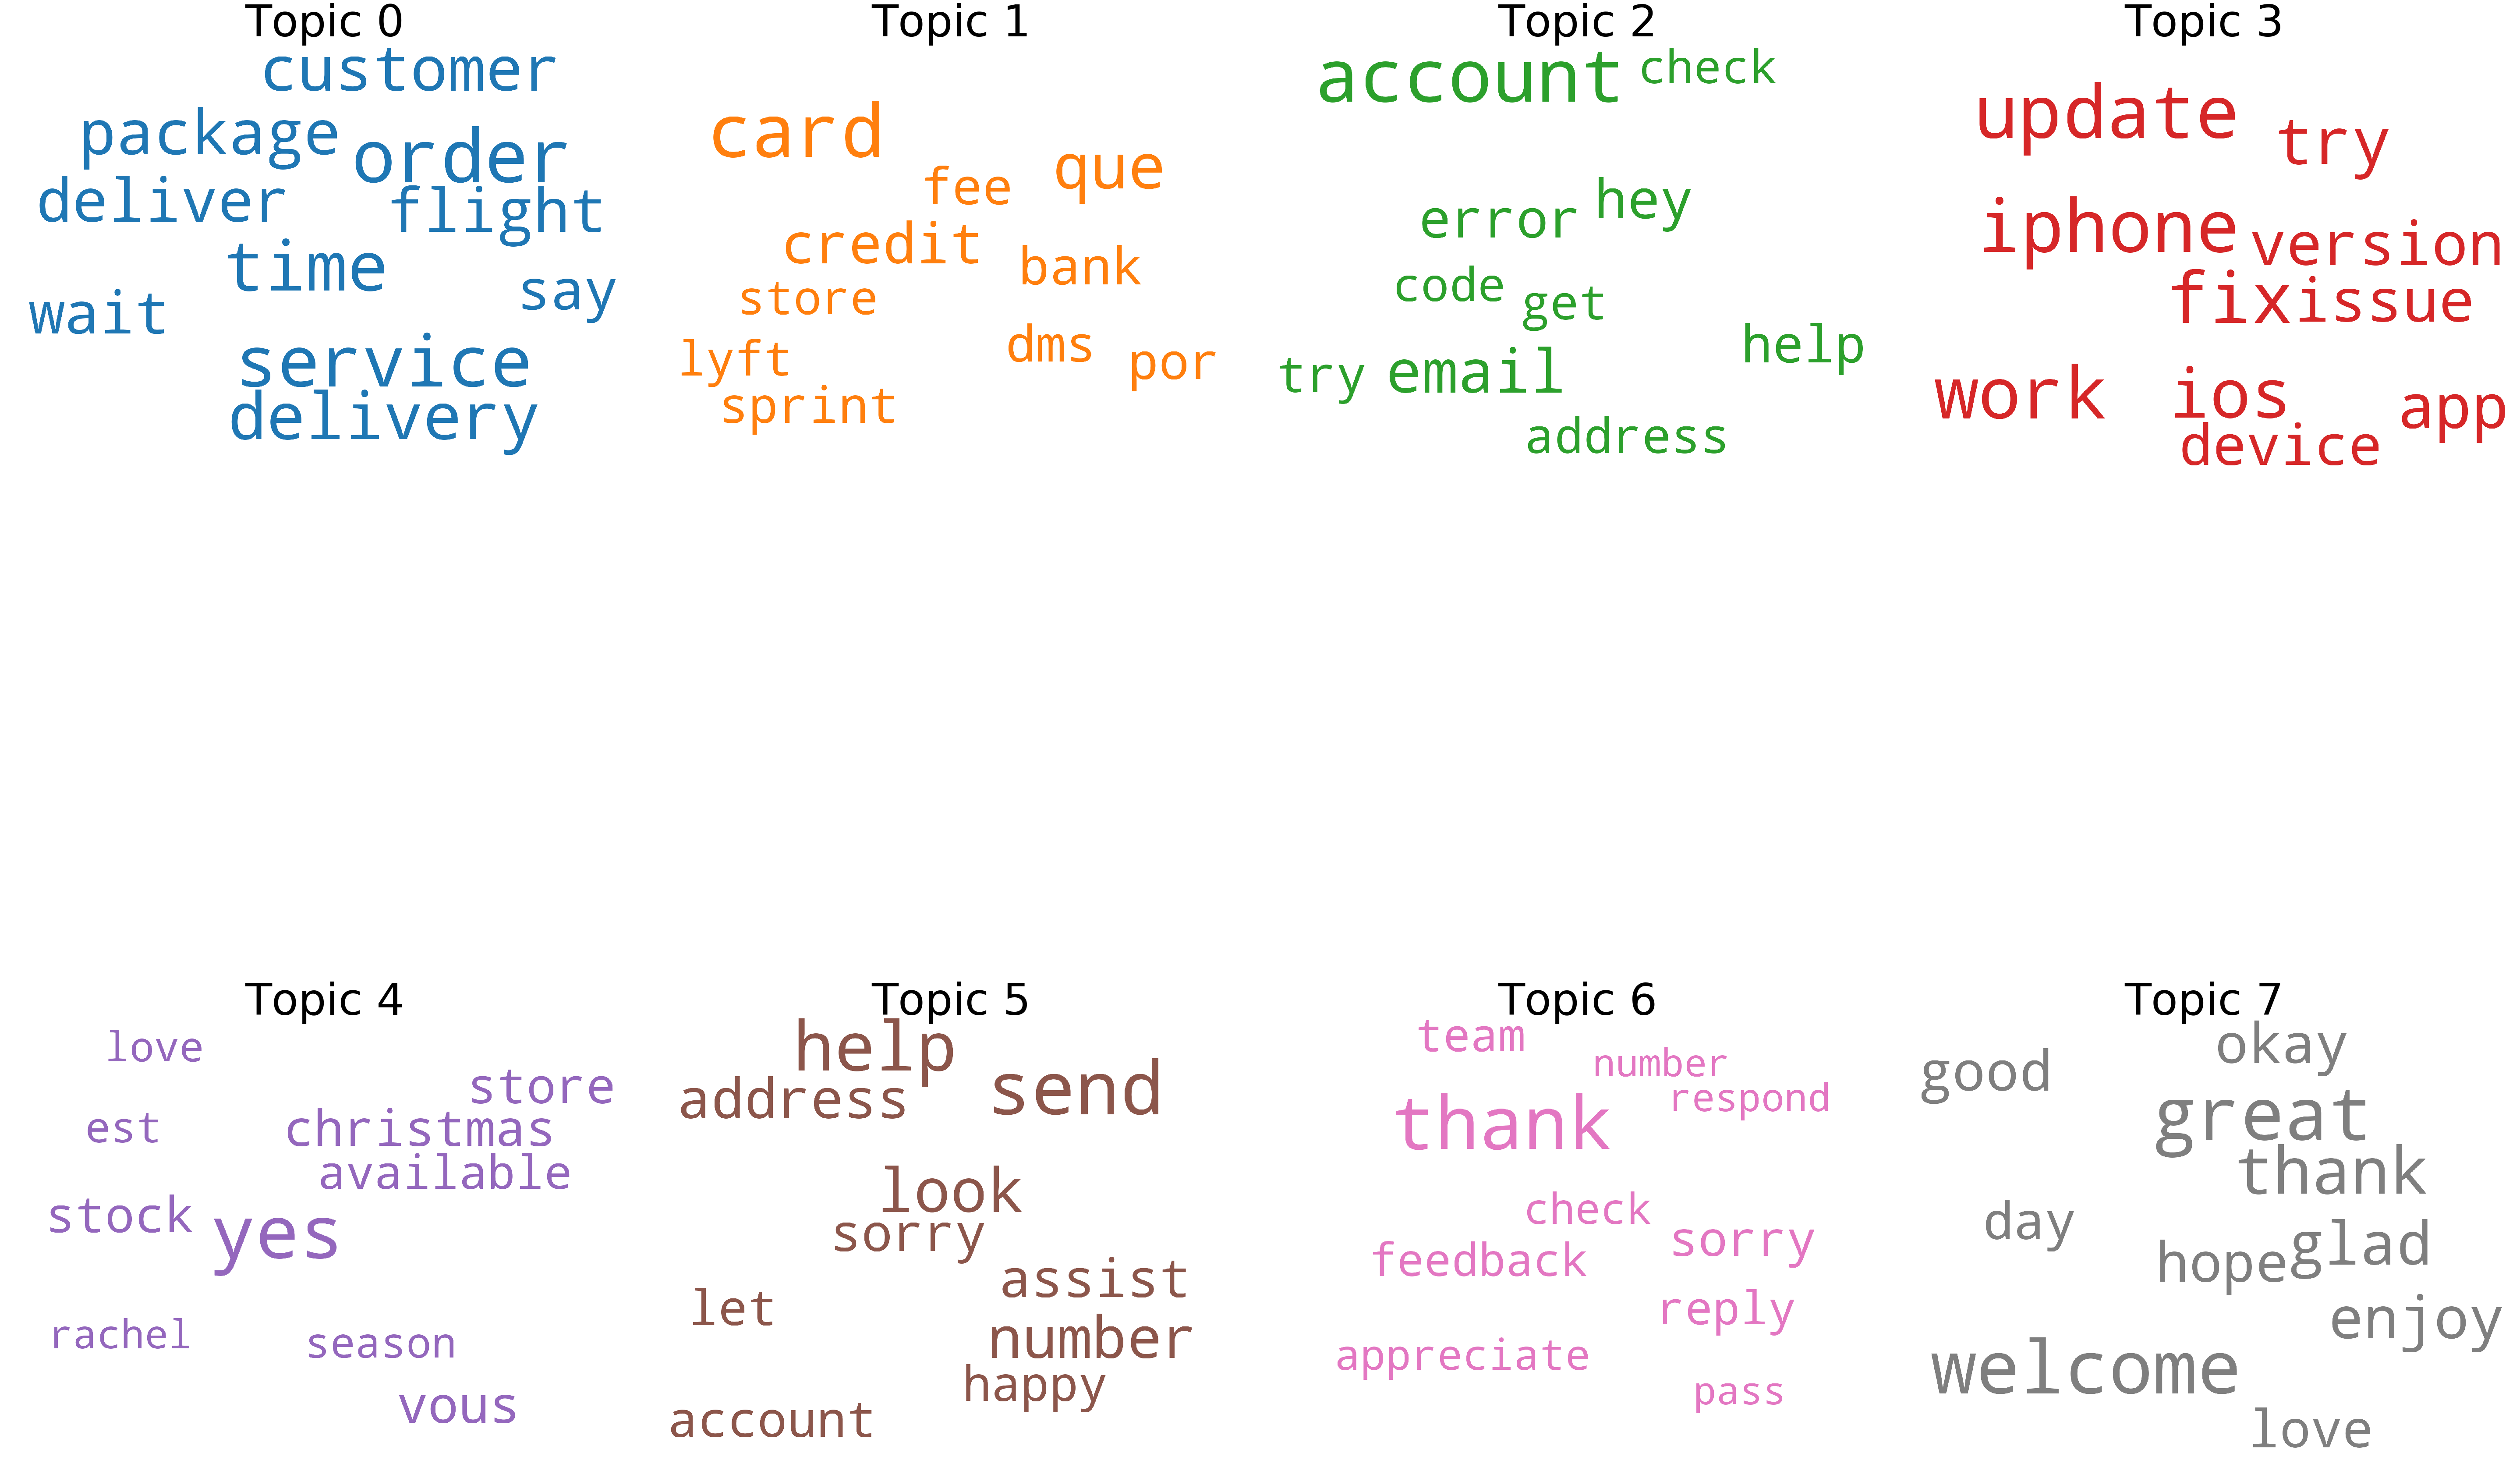

In [13]:
# wordclouds

topics = lda_model_tfidf.show_topics(formatted=False)

from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(2, 4, figsize=(80,80), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=100))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [14]:
# visualization of the model

%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model_tfidf, corpus=corpus_tfidf, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/opt/conda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
